## Specification of start years for PPEs
Seeking start years that are ~25 years apart and sample multi-decadal variability of Southern Ocean ventilation
- calculate AABW overturning strength
- get pdf of AABW overturning strength
- sample evenly from this pdf

Also look at quantities such as ENSO to ensure even sampling.

***

**9.21.21** Using [Jenson-Shannon Distance](https://medium.com/@sourcedexter/how-to-find-the-similarity-between-two-probability-distributions-using-python-a7546e90a08d) to select years that give NINO34 distribution most similar to full time-series. Uncertain about reliability of this measure when sampled distribution is so sparse (n=10).  

This notebook also uses a confusing amalgamation of pandas DataFrames and xarray Datasets. I think I only need to use xarray up to the point of calculating and loading the timeseries'. After this, load into a DataFrame and

**9.21.21** ENSO statistics determined manually, now trying to implement a more rigorous checking. Redoing primary threshold selection for average Southern Ocean salinity.

**9.21.21** Sampling revised to select evenly from _percentile_ bins, e.g. one from 0 to 10 percentil, 1 from 10 to 20 percentile, etc. This returns a sample with the same AABW strength pdf as the original distribution.  
Now need to check ENSO statistics.

**9.20.21** Realised that sampling strategy based on selecting one year from each of 10 bins actually gives a **uniform** distribution across sampled AABW strengths. This is of course not the same statistics as the control. So, I think I actually want to take from each bin a number of start years consistent with a discrete normal distribution. This would be, I think, (0,0,0,2,3,3,2,0,0,0).

In [21]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import pandas as pd
import glob
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats

In [22]:
# Mass transport for AABW
paths = '../data/raw/CTRL/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.0[2-4]*.vmo.nc'
ds = xr.open_mfdataset(glob.glob(paths),use_cftime=True)
# Surface temperature for ENSO
paths = '../data/raw/CTRL/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.0[2-4]*.tos.nc'
dstos = (xr.open_mfdataset(glob.glob(paths),use_cftime=True)
         # Use groupby to pick out years (coarsen doesn't like cftime)
         .groupby('time.year').mean().rename({'year':'time'})
         # Align coords with ds
         .assign_coords({'time':ds['time']}).drop('average_DT'))
# Surface salinity
paths = '../data/raw/CTRL/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.0[2-4]*.sos.nc'
dssos = (xr.open_mfdataset(glob.glob(paths),use_cftime=True)
         # Use groupby to pick out years (coarsen doesn't like cftime)
         .groupby('time.year').mean().rename({'year':'time'})
         # Align coords with ds
         .assign_coords({'time':ds['time']}).drop('average_DT'))
ds = xr.merge([ds,dstos,dssos])
# Grid
gridpath = '../data/raw/CTRL/pp/ocean_annual_rho2/ocean_annual_rho2.static.nc'
grid = xr.open_mfdataset(glob.glob(gridpath))

In [32]:
def cumsum_r(da,dim):
    '''Reverse cumulative sum'''
    cumsum = da.reindex({dim:list(reversed(da[dim]))}).cumsum(dim)
    return cumsum.reindex({dim:list(reversed(cumsum[dim]))})

def calc_psi(vmo,latitude,zdim='rho2_l'):
    '''Calculate overturning streamfunction'''
    return cumsum_r(vmo.sum('xh').sel(yq=latitude,method='nearest'),dim='rho2_l')

def calc_maxpsi(vmo,latitude,zdim='rho2_l',threshold=1036.7):
    '''Retrieve maximum of psi in z-dimension'''
    psi = calc_psi(vmo,latitude,zdim=zdim)
    return psi.where(psi[zdim]>threshold).max(zdim)

def calc_nino34(tos,area):
    box_dict = {'xh':slice(-170,-120),'yh':slice(-5,5)}
    tos_box = tos.sel(**box_dict).weighted(area).mean(['xh','yh'])
    return (tos_box - tos_box.mean('time'))/tos_box.std('time')

def calc_sosalinity(sos,area):
    box_dict = {'yh':slice(-90,-55)}
    sos_box = sos.sel(**box_dict).weighted(area).mean(['xh','yh'])
    return sos_box

In [100]:
vmo = ds['vmo']
tos = ds['tos']
sos = ds['sos']
maxpsi = calc_maxpsi(vmo,-60)
maxpsi.name = 'maxpsi'
nino34 = calc_nino34(tos,grid['areacello'])
nino34.name = 'nino34'
sosalinity = calc_sosalinity(sos,grid['areacello'])
sosalinity.name = 'sosalinity'
with ProgressBar():
    maxpsi = maxpsi.load()
    nino34 = nino34.load()
    sosalinity = sosalinity.load()

[########################################] | 100% Completed |  1min  4.7s
[                                        ] | 1% Completed |  0.9s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 11.8s
[########################################] | 100% Completed | 11.3s


In [101]:
df = pd.DataFrame({'maxpsi':maxpsi,
                   'nino34':nino34,
                   'sosalinity':sosalinity,
                   'time':np.arange(len(maxpsi['time']))})
df

,maxpsi,nino34,sosalinity,time
0,6.666611e+09,-1.086424,33.971519,0
1,1.302081e+10,-0.936914,33.970509,1
2,1.482284e+10,-0.994717,33.948593,2
3,1.358757e+10,0.171818,33.957409,3
4,1.666255e+10,-0.079366,33.967575,4
...,...,...,...,...
295,1.029211e+10,0.899994,33.899212,295
296,1.061461e+10,1.541302,33.903149,296
297,9.624909e+09,-1.376003,33.921276,297
298,1.054232e+10,-1.941309,33.912048,298


In [102]:
# Calculate percentiles
primaryvar = 'sosalinity'
bins = df.quantile(q=np.arange(0,1.1,0.1))[primaryvar].to_numpy()
bins

array([33.80485153, 33.87454224, 33.89128342, 33.90932083, 33.92478638,
       33.93990898, 33.95072784, 33.95765228, 33.96420059, 33.97375221,
       34.01911545])

In [210]:
def grab(x):
    return np.random.choice(x,1)[0]

def find_years(groups):
    times = groups['time'].apply(grab)
    years = np.sort(times.to_numpy())
    return years

def eval_spacing(years,minspacing=10):
    return np.all(np.greater(np.diff(years),minspacing))

# def get_years_with_spacing(groups,minspacing=10,check_alt=False,alt_ts=None, thresholds=None):
#     success=False
#     ni=0
#     while not success:
#         years = find_years(groups)
#         success = eval_spacing(years,minspacing=minspacing)
#         if success:
#             print("FOUND : suitable years after {} iterations".format(ni))
#             print("Years : {}".format(years))
#             print("Spacing : {}".format(np.diff(years)))
#             if check_alt:
#                 success,full,sample = check_sample_meanstd(alt_ts,years,thresholds)
#                 if not allgreater:
#                     print("FAIL : years don't satisfy thresholds for alternative time-series")
#                     print("FAIL : ts mean {}, std {}".format(full[0].values,full[1].values))
#                     print("FAIL : sample ts mean {}, std {}".format(sample[0].values,sample[0].values))
#                 else:
#                     print("SUCCESS : years satisfy alternative timeseries thresholds")
#         ni+=1
#     return years

def get_years_with_spacing(groups,minspacing=10,check_alt=False,alt_ts=None, thresholds=None):
    success=False
    ni=0
    while not success:
        years = find_years(groups)
        success = eval_spacing(years,minspacing=minspacing)
        if success:
            print("FOUND : suitable years after {} iterations".format(ni))
            print("Years : {}".format(years))
            print("Spacing : {}".format(np.diff(years)))
        ni+=1
    return years

def check_sample_meanstd(ts,years,thresholds):
    '''Compare mean and std of sampled years to that of full time-series
    Input threshold as list of [threshold for mean, threshold for std]
    Outputs come as (boolean, [mean,std] for full ts, [mean,std] for sample)'''
    diffmean = np.abs(ts.mean('time') - ts.isel(time=years).mean('time'))
    diffstd = np.abs(ts.std('time') - ts.isel(time=years).std('time'))
    return (
        (diffmean<thresholds[0]) & (diffstd<thresholds[1]),
        [ts.mean('time'), ts.std('time')],
        [ts.isel(time=years).mean('time'),ts.isel(time=years).std('time')]
    )

def calc_jsd(p,q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """
    # from here https://medium.com/@sourcedexter/how-to-find-the-similarity-between-two-probability-distributions-using-python-a7546e90a08d
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)
    # calculate m
    m = (p + q) / 2
    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    # If two distribution differ only at level of machine precision,
    # set divergence to zero (to avoid negative numbers)
    if divergence<0:
        divergence = 0
    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)
    return distance

def get_jsd(ts,years,bins=30):
    p,q,_ = get_distributions(ts,years,bins)
    return calc_jsd(p,q)

def get_quantile_bins(ts):
    return ts.quantile(q=np.arange(0,1.1,0.1)).to_numpy()

def get_distributions(ts,years,bins=30):
    if isinstance(bins,int):
        bins = np.linspace(np.min(ts),np.max(ts),bins)
    sample = ts.isel(time=years)
    # Get pdf for full time-series
    ts_hist = histogram(ts,bins=[bins],dim=['time'],density=True)
    # Get pdf for sample
    sample_hist = histogram(sample,bins=[bins],dim=['time'],density=True)
    return ts_hist,sample_hist,bins

def plot_distributions(ts,years,bins=30,print_years=True,print_jsd=True):
    sample = ts.isel(time=years)
    ts_hist,sample_hist,bin_edges = get_distributions(ts,years,bins=bins)
    
    fig = plt.figure(constrained_layout=True,figsize=(15,5))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0:2])
    ax2 = fig.add_subplot(spec[2])

    ax1.plot(ts['time'],ts)
    ax1.plot(sample['time'],sample,'o',markersize=12)
    ax1.set_xlabel('Time')
    ax1.autoscale(enable=True, axis='x', tight=True)
    if print_years:
        ylims = ax1.get_ylim()
        ypos = ylims[0]-np.diff(ylims)*0.2
        ax1.text(ts['time'][0].values,ypos,
                 "Years : "+np.array2string(years,separator=', ')+
                 ";  Min. spacing : "+str(np.min(np.diff(years))),fontsize=16)

    ax2.plot(ts_hist[ts.name+'_bin'],ts_hist)
    ax2.bar(sample_hist[sample.name+'_bin'],sample_hist,width=np.diff(bin_edges),color='tab:orange',alpha=0.5,edgecolor='tab:orange')
    ax2.set_ylabel('probability density') 
    if print_jsd:
        xlims = ax2.get_xlim()
        ylims = ax2.get_ylim()
        xpos = xlims[0]+np.diff(xlims)*0.1
        ypos = ylims[1]-np.diff(ylims)*0.1
        
        distance = get_jsd(ts,years)
        ax2.text(xpos,ypos,"JSD : {}".format(distance))


In [187]:
dfshort=df[:-10] # Ensemble runs could be up to 10 years, so constrain to be within first 290 years
bins_pd = pd.cut(dfshort[primaryvar],bins)
groups = dfshort.groupby(bins_pd)

FOUND : suitable years after 6578 iterations
Years : [ 25  55  83 105 129 159 189 214 239 274]
Spacing : [30 28 22 24 30 30 25 25 35]
CPU times: user 11.8 s, sys: 36.5 ms, total: 11.9 s
Wall time: 11.9 s
Jenson-Shannon Distance : 0.5120977094375524


In [202]:
ni=0
maxni = 10
distance = 1
while ni<maxni:
    yearsnow = get_years_with_spacing(groups,minspacing=20)
    distancenow = get_jsd(nino34,yearsnow)
    print("Jenson-Shannon Distance : {}".format(distancenow))
    if distancenow<distance:
        distance = distancenow
        years = yearsnow
    ni+=1
print(" ")
print("After finding {} suitable samples, ".format(ni))
print("Smallest JSD  = {}".format(distance))
print("For years : "+np.array2string(years,separator=', '))

FOUND : suitable years after 1592 iterations
Years : [  8  39  76 109 141 178 204 236 260 281]
Spacing : [31 37 33 32 37 26 32 24 21]
Jenson-Shannon Distance : 0.54500483298201
FOUND : suitable years after 5795 iterations
Years : [ 13  49  71  92 117 143 169 197 222 266]
Spacing : [36 22 21 25 26 26 28 25 44]
Jenson-Shannon Distance : 0.5045964872135623
FOUND : suitable years after 3087 iterations
Years : [ 16  38  66  87 113 137 165 197 243 273]
Spacing : [22 28 21 26 24 28 32 46 30]
Jenson-Shannon Distance : 0.5540351961105245
FOUND : suitable years after 20539 iterations
Years : [  2  27  50  72  95 136 157 186 233 288]
Spacing : [25 23 22 23 41 21 29 47 55]
Jenson-Shannon Distance : 0.5816412973273707
FOUND : suitable years after 916 iterations
Years : [  8  46  79 114 143 180 202 242 266 288]
Spacing : [38 33 35 29 37 22 40 24 22]
Jenson-Shannon Distance : 0.593294808222562
FOUND : suitable years after 487 iterations
Years : [ 13  44  73  94 115 139 192 223 244 278]
Spacing : [31 

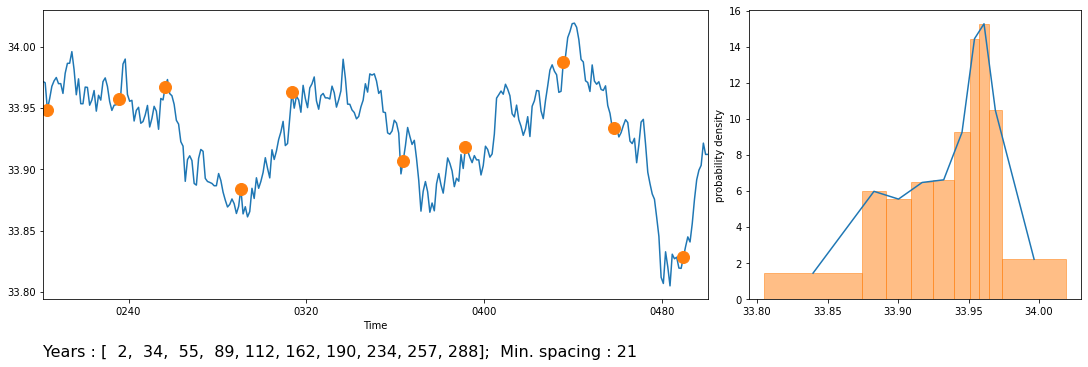

In [211]:
plot_distributions(sosalinity,years,bins=get_quantile_bins(sosalinity),print_jsd=False)

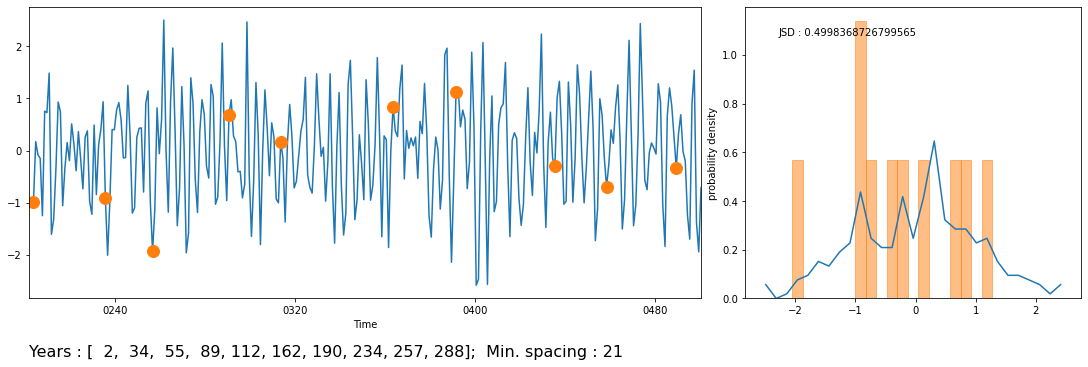

In [212]:
plot_distributions(nino34,years)

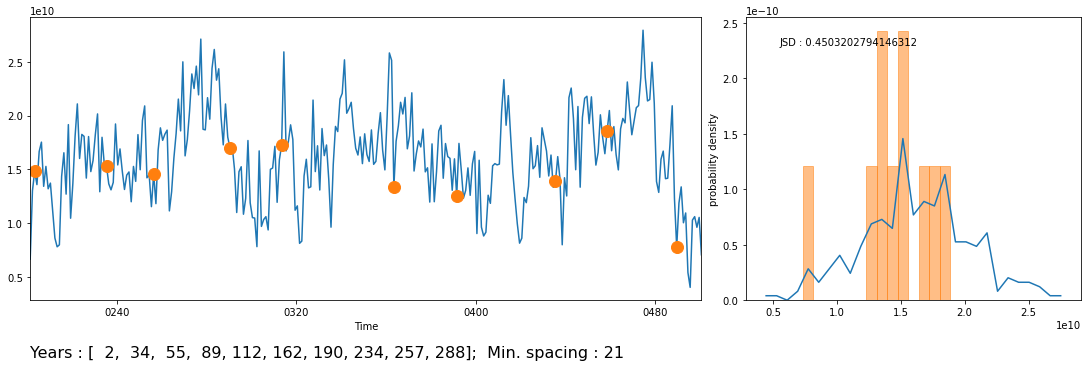

In [213]:
plot_distributions(maxpsi,years)